# LSGANs - Least Squares Generative Adversarial Networks

Brief introduction to Least Squares Generative Adversarial Networks or LSGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training WGAN with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Least Squares Generative Adversarial Networks](https://arxiv.org/pdf/1611.04076.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Least Squares Generative Adversarial Networks (LSGANs) adopt the **least squares loss function** for the discriminator.

The least squares loss function is able to move the fake samples toward the decision boundary, because the least squares loss function penalizes samples that lie in a long way on the correct side of the decision boundary.

Another benefit of LSGANs is the improved stability of learning process.

### Network Design

<img src="../../img/network_design_gan.png" width="600">


### Cost Funcion

$$
\begin{aligned}
    \underset{D}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{x\sim p_{data}(x)}[(D(x)-b)^2] + \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-a)^2] \\
    \underset{G}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-c)^2]
\end{aligned}
$$

where $a$ and $b$ are the labels for fake data and real data, respectively, and $c$ denotes the value that G wants D to believe for fake data.

## 4. Training LSGANs with MNIST dataset, Keras and TensorFlow

* Data
    * Rescale the MNIST images to be between -1 and 1.

* Generator
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator is called 'latent sample' (100 values) which is a series of randomly generated numbers, and produces 784 (=28x28) data points which represent a digit image. We use the **normal distribution**.
        The last activation is **tanh**.

* Discriminator
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The last activation is **sigmoid**.

*  Loss
    * loss='mse'

* Optimizer
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Reshape
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K

#### Getting the data

In [ ]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#### Explore visual data

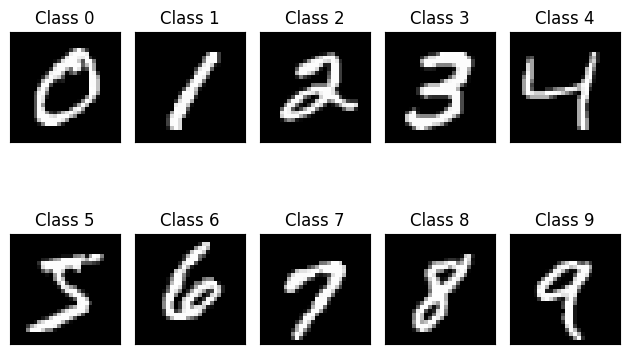

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

#### Reshaping and normalizing the inputs

In [ ]:
print('X_train.shape', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator


In [ ]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [ ]:
# prints a summary representation of your model
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

#### Discriminator

In [ ]:
# Discriminator network
discriminator = Sequential()

# Hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


#### Discriminator model visualization

In [ ]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

### 3. Compile model

#### Compile discriminator

In [ ]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='mse', metrics=['binary_accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Combined network

In [ ]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

# Optimize w.r.t. MSE loss instead of crossentropy
d_g.compile(optimizer=optimizer, loss='mse', metrics=['binary_accuracy'])

In [ ]:
# prints a summary representation of your model
d_g.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               583312    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 265601    
                                                                 
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


### 4. Fit model


epoch = 1/100, d_loss=0.193, g_loss=0.411                                                                                                     
1/1 [==============================] - 0s 93ms/step


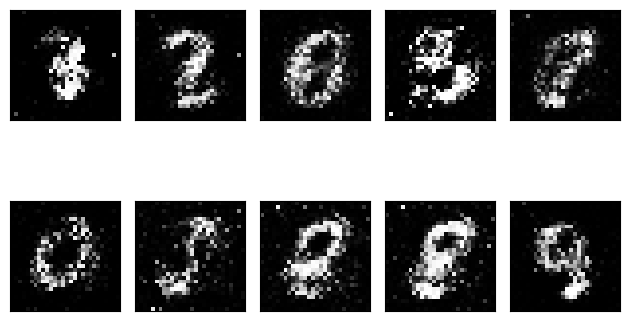

epoch = 2/100, d_loss=0.202, g_loss=0.403                                                                                                     
epoch = 3/100, d_loss=0.216, g_loss=0.416                                                                                                     
epoch = 4/100, d_loss=0.240, g_loss=0.306                                                                                                     
epoch = 5/100, d_loss=0.184, g_loss=0.425                                                                                                     
epoch = 6/100, d_loss=0.222, g_loss=0.397                                                                                                     
epoch = 7/100, d_loss=0.177, g_loss=0.347                                                                                                     
epoch = 8/100, d_loss=0.168, g_loss=0.311                                                                                                     

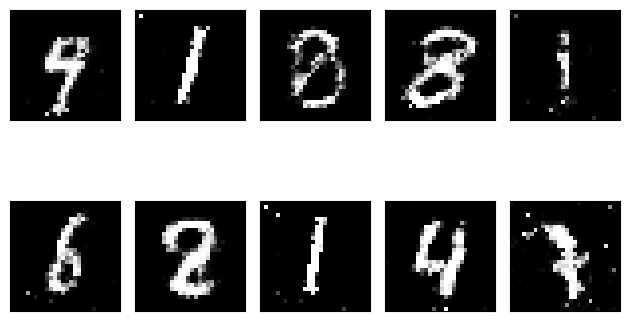

epoch = 12/100, d_loss=0.183, g_loss=0.361                                                                                                     
epoch = 13/100, d_loss=0.231, g_loss=0.425                                                                                                     
epoch = 14/100, d_loss=0.195, g_loss=0.309                                                                                                     
epoch = 15/100, d_loss=0.204, g_loss=0.453                                                                                                     
epoch = 16/100, d_loss=0.202, g_loss=0.402                                                                                                     
epoch = 17/100, d_loss=0.204, g_loss=0.392                                                                                                     
epoch = 18/100, d_loss=0.155, g_loss=0.412                                                                                              

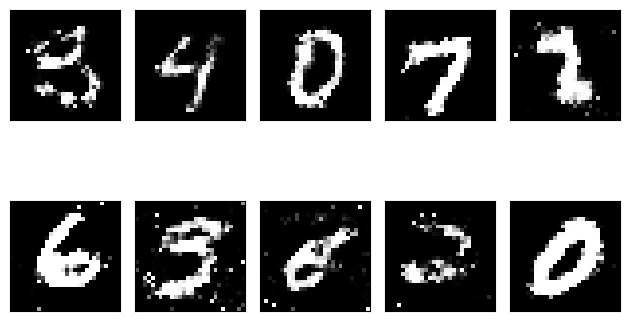

epoch = 22/100, d_loss=0.170, g_loss=0.412                                                                                                     
epoch = 23/100, d_loss=0.180, g_loss=0.432                                                                                                     
epoch = 24/100, d_loss=0.205, g_loss=0.517                                                                                                     
epoch = 25/100, d_loss=0.151, g_loss=0.392                                                                                                     
epoch = 26/100, d_loss=0.192, g_loss=0.416                                                                                                     
epoch = 27/100, d_loss=0.184, g_loss=0.417                                                                                                     
epoch = 28/100, d_loss=0.163, g_loss=0.490                                                                                              

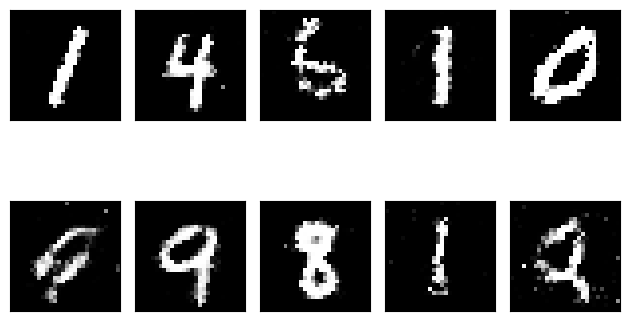

epoch = 32/100, d_loss=0.159, g_loss=0.471                                                                                                     
epoch = 33/100, d_loss=0.135, g_loss=0.422                                                                                                     
epoch = 34/100, d_loss=0.211, g_loss=0.415                                                                                                     
epoch = 35/100, d_loss=0.194, g_loss=0.468                                                                                                     
epoch = 36/100, d_loss=0.167, g_loss=0.569                                                                                                     
epoch = 37/100, d_loss=0.117, g_loss=0.446                                                                                                     
epoch = 38/100, d_loss=0.160, g_loss=0.584                                                                                              

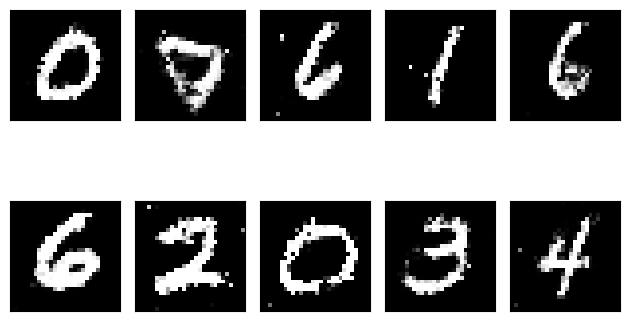

epoch = 42/100, d_loss=0.201, g_loss=0.480                                                                                                     
epoch = 43/100, d_loss=0.148, g_loss=0.501                                                                                                     
epoch = 44/100, d_loss=0.202, g_loss=0.488                                                                                                     
epoch = 45/100, d_loss=0.169, g_loss=0.528                                                                                                     
epoch = 46/100, d_loss=0.155, g_loss=0.544                                                                                                     
epoch = 47/100, d_loss=0.170, g_loss=0.501                                                                                                     
epoch = 48/100, d_loss=0.144, g_loss=0.472                                                                                              

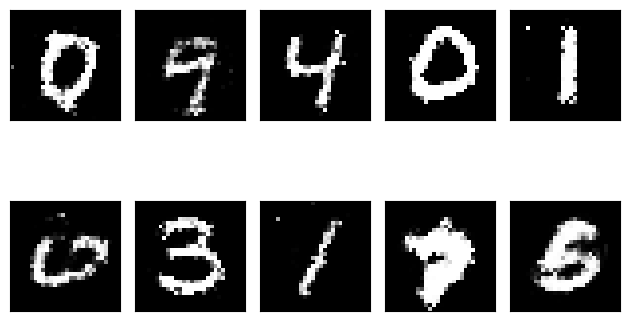

epoch = 52/100, d_loss=0.172, g_loss=0.430                                                                                                     
epoch = 53/100, d_loss=0.150, g_loss=0.488                                                                                                     
epoch = 54/100, d_loss=0.143, g_loss=0.565                                                                                                     
epoch = 55/100, d_loss=0.207, g_loss=0.524                                                                                                     
epoch = 56/100, d_loss=0.148, g_loss=0.610                                                                                                     
epoch = 57/100, d_loss=0.168, g_loss=0.579                                                                                                     
epoch = 58/100, d_loss=0.177, g_loss=0.496                                                                                              

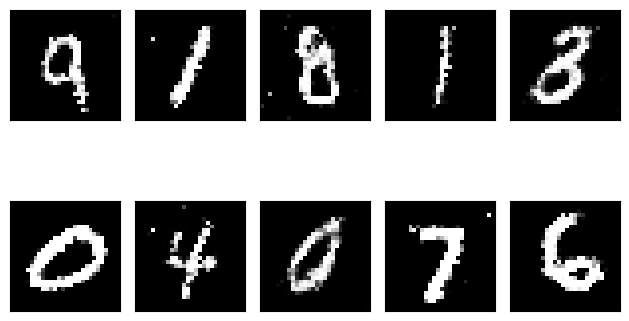

epoch = 62/100, d_loss=0.138, g_loss=0.516                                                                                                     
epoch = 63/100, d_loss=0.120, g_loss=0.461                                                                                                     
epoch = 64/100, d_loss=0.176, g_loss=0.477                                                                                                     
epoch = 65/100, d_loss=0.133, g_loss=0.457                                                                                                     
epoch = 66/100, d_loss=0.152, g_loss=0.482                                                                                                     
epoch = 67/100, d_loss=0.132, g_loss=0.635                                                                                                     
epoch = 68/100, d_loss=0.208, g_loss=0.610                                                                                              

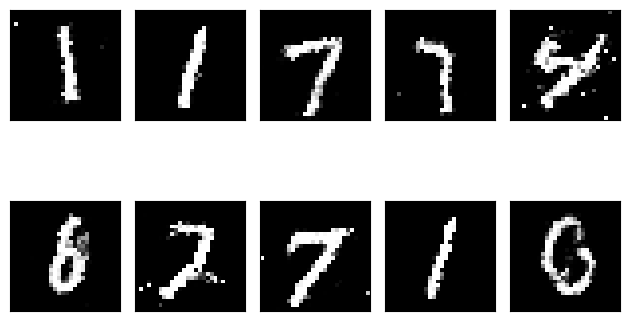

epoch = 72/100, d_loss=0.124, g_loss=0.524                                                                                                     
epoch = 73/100, d_loss=0.153, g_loss=0.519                                                                                                     
epoch = 74/100, d_loss=0.184, g_loss=0.579                                                                                                     
epoch = 75/100, d_loss=0.108, g_loss=0.505                                                                                                     
epoch = 76/100, d_loss=0.134, g_loss=0.467                                                                                                     
epoch = 77/100, d_loss=0.125, g_loss=0.607                                                                                                     
epoch = 78/100, d_loss=0.092, g_loss=0.466                                                                                              

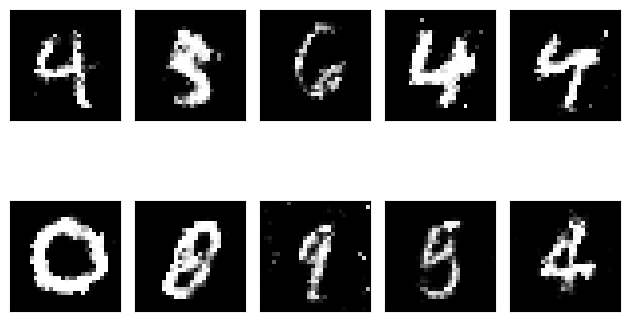

epoch = 82/100, d_loss=0.130, g_loss=0.556                                                                                                     
epoch = 83/100, d_loss=0.136, g_loss=0.532                                                                                                     
epoch = 84/100, d_loss=0.130, g_loss=0.527                                                                                                     
epoch = 85/100, d_loss=0.160, g_loss=0.713                                                                                                     
epoch = 86/100, d_loss=0.149, g_loss=0.501                                                                                                     
epoch = 87/100, d_loss=0.129, g_loss=0.595                                                                                                     
epoch = 88/100, d_loss=0.137, g_loss=0.467                                                                                              

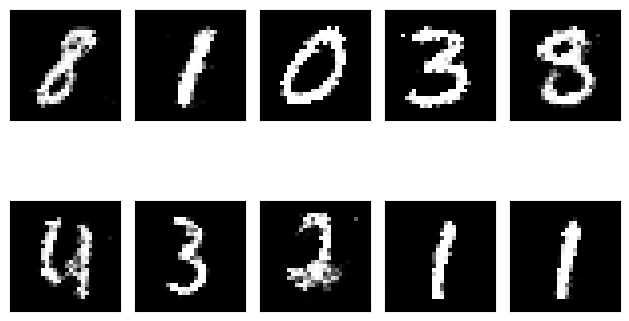

epoch = 92/100, d_loss=0.178, g_loss=0.567                                                                                                     
epoch = 93/100, d_loss=0.126, g_loss=0.599                                                                                                     
epoch = 94/100, d_loss=0.083, g_loss=0.595                                                                                                     
epoch = 95/100, d_loss=0.166, g_loss=0.620                                                                                                     
epoch = 96/100, d_loss=0.116, g_loss=0.465                                                                                                     
epoch = 97/100, d_loss=0.175, g_loss=0.697                                                                                                     
epoch = 98/100, d_loss=0.146, g_loss=0.548                                                                                              

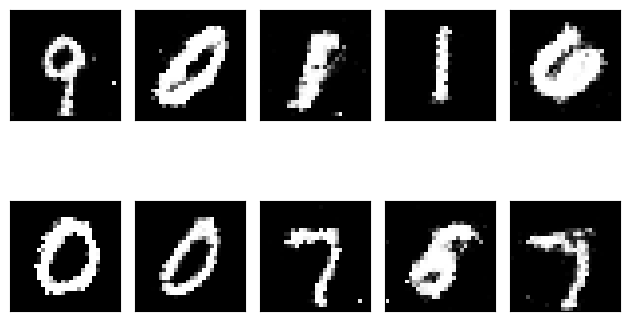

In [ ]:
epochs = 1
batch_size = 32

a = np.zeros(shape=(batch_size//2, 1))
b = np.ones(shape=(batch_size//2, 1))
c = np.ones(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_real = X_train[i*batch_size//2:(i+1)*batch_size//2]

        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size//2, latent_dim))
        X_fake = generator.predict_on_batch(z)

        # Discriminator loss
        d_loss_batch = discriminator.train_on_batch(
            x=np.concatenate((X_fake, X_real), axis=0),
            y=np.concatenate((a, b), axis=0)
        )

        # Train Generator weights
        discriminator.trainable = False

        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        d_g_loss_batch = d_g.train_on_batch(x = z, y = c)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch[0], d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )

    d_loss.append(d_loss_batch[0])
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

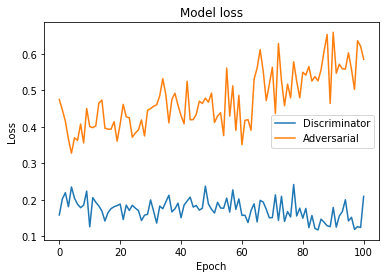

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()